# Sentiment Analysis

In this NB I try to work out what are the categories of the types of questions people are asking to the chatbot. Using this information we can gain a better understanding about what our users want to use the chatbot for and if there is any drift between what we think and what they want. This way we can better steer the chatbot to behave better for the users

First I start with an estimated guess of the categories basic on an initial look at the dataset and use the [t-SNE method](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to fit the data. After showing that this approach doesn't always yield the best results and is often bias, I move onto using an automatic cluster detection method using [k-means](https://en.wikipedia.org/wiki/K-means_clustering) vector quantisation and a GPT to auto-name the clusters and again collapse the vectors to 2 dimensions with t-SNE to fit the and visually represent the data.

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List
from openai import OpenAI
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [2]:
EMBEDDING_MODEL = 'text-embedding-ada-002'
client = OpenAI()

# Define initial empirically defined clusters from initial look at the data
clusters = {
    "Healthy Recipes": ["What are some heart-healthy vegetarian recipes for dinner?", "Can you suggest low-fat smoothie recipes for breakfast?", "How do I make a healthy and flavorful quinoa salad?"],
    "Special Diets": ["What are some gluten-free meal options for people with celiac disease?", "Can you provide keto-friendly dessert recipes?", "What are some vegan alternatives to traditional dairy products in cooking?"],
    "Baking Techniques": ["What's the key to achieving the perfect rise in sourdough bread?", "How can I ensure my cakes are moist and fluffy every time?", "What are some tips for making flaky and buttery croissants?"],
    "International Cuisine": ["How do I prepare an authentic Japanese sushi at home?", "Can you guide me through making a classic Italian lasagna?", "What are the essential ingredients for a traditional Thai green curry?"],
    "Unrelated (General Knowledge)": ["How to build a car?", "Who is Elvis Presley?", "What are the basic steps to start a home garden?", "How can I improve my time management skills?", "What are some effective ways to reduce stress in daily life?"]

}

### Define some helper functions

In [3]:
def get_embedding(texts: List[str], model: str = EMBEDDING_MODEL) -> List[float]:
    """Generates embeddings for the given text using the OpenAI Embeddings API."""
    result = client.embeddings.create(
        model=model,
        input=texts
    )
    return [obj.embedding for obj in result.data]


def vector_similarity(x: list[float], y: list[float]) -> float:
    """
    Returns the similarity between two vectors.

    Because OpenAI Embeddings are normalised to length 1, the cosine similarity is the same as the dot product.
    """
    return np.dot(np.array(x).flatten(), np.array(y).flatten())

def load_questions(file_path):
    questions = None
    with open(file_path, 'r') as file:
        questions = json.load(file)
    return questions

## Generate embeddings

In [4]:
# Create mean embeddings for clusters
cluster_embeddings = {cluster: np.mean(get_embedding(questions), axis=0) for cluster, questions in clusters.items()}

In [5]:
# Import and embed questions
questions = load_questions('./output_questions.json')
question_embeddings = get_embedding(questions)

## Analyse the closeness

Take a look at the "closeness" (i.e. vector distance) of the asked questions to the suggested clusters in the embedding space.

Text(0.5, 1.0, 'Question counts per category')

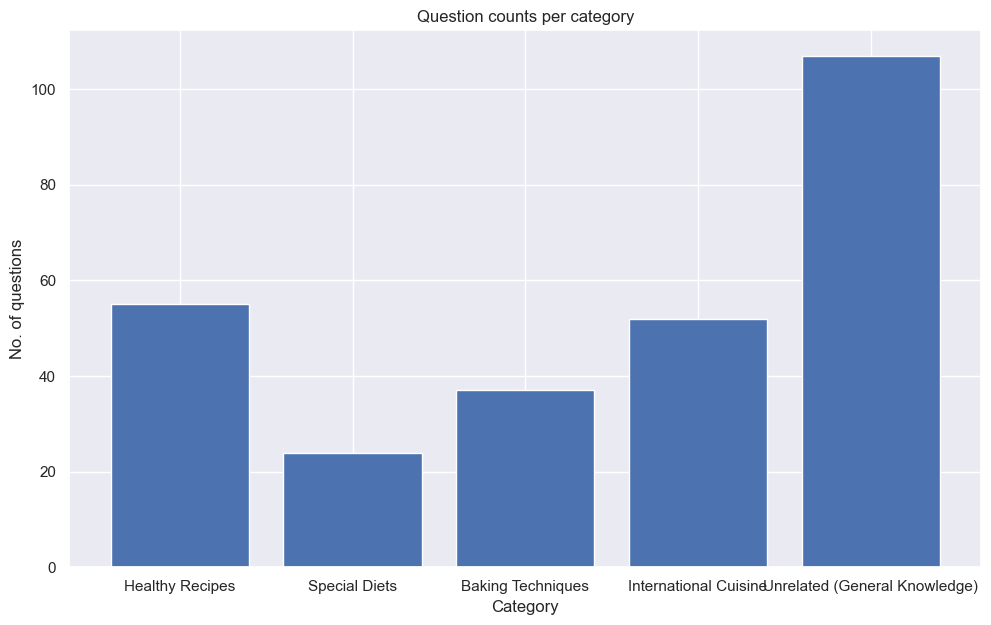

In [6]:
counts = dict.fromkeys(clusters.keys(), 0)
for question, query_embedding in zip(questions, question_embeddings):
    distances = {cluster: vector_similarity([query_embedding], [cluster_embedding]) for cluster, cluster_embedding in cluster_embeddings.items()}
    closest_topic = max(distances, key=distances.get)
    counts[closest_topic] = counts[closest_topic] + 1
#     print(f"Question: {question}\nClosest Topic: {closest_topic}\n")

sns.set_theme()
plt.figure(figsize=(10, 6))
plt.bar(*zip(*counts.items()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()))
plt.tight_layout()
plt.xlabel("Category")
plt.ylabel("No. of questions")
plt.title("Question counts per category")

Either people are posing questions very unrelated to our core theme of cooking or our intuition of our clusters is incorrect.

Let's try visualising the data as a heatmap. We create a normalised matrix of the questions and clusters where each element of the matrix represents that question's similarity to the cluster.

Text(0.5, 1.0, 'Question-Topic Similarity Scores')

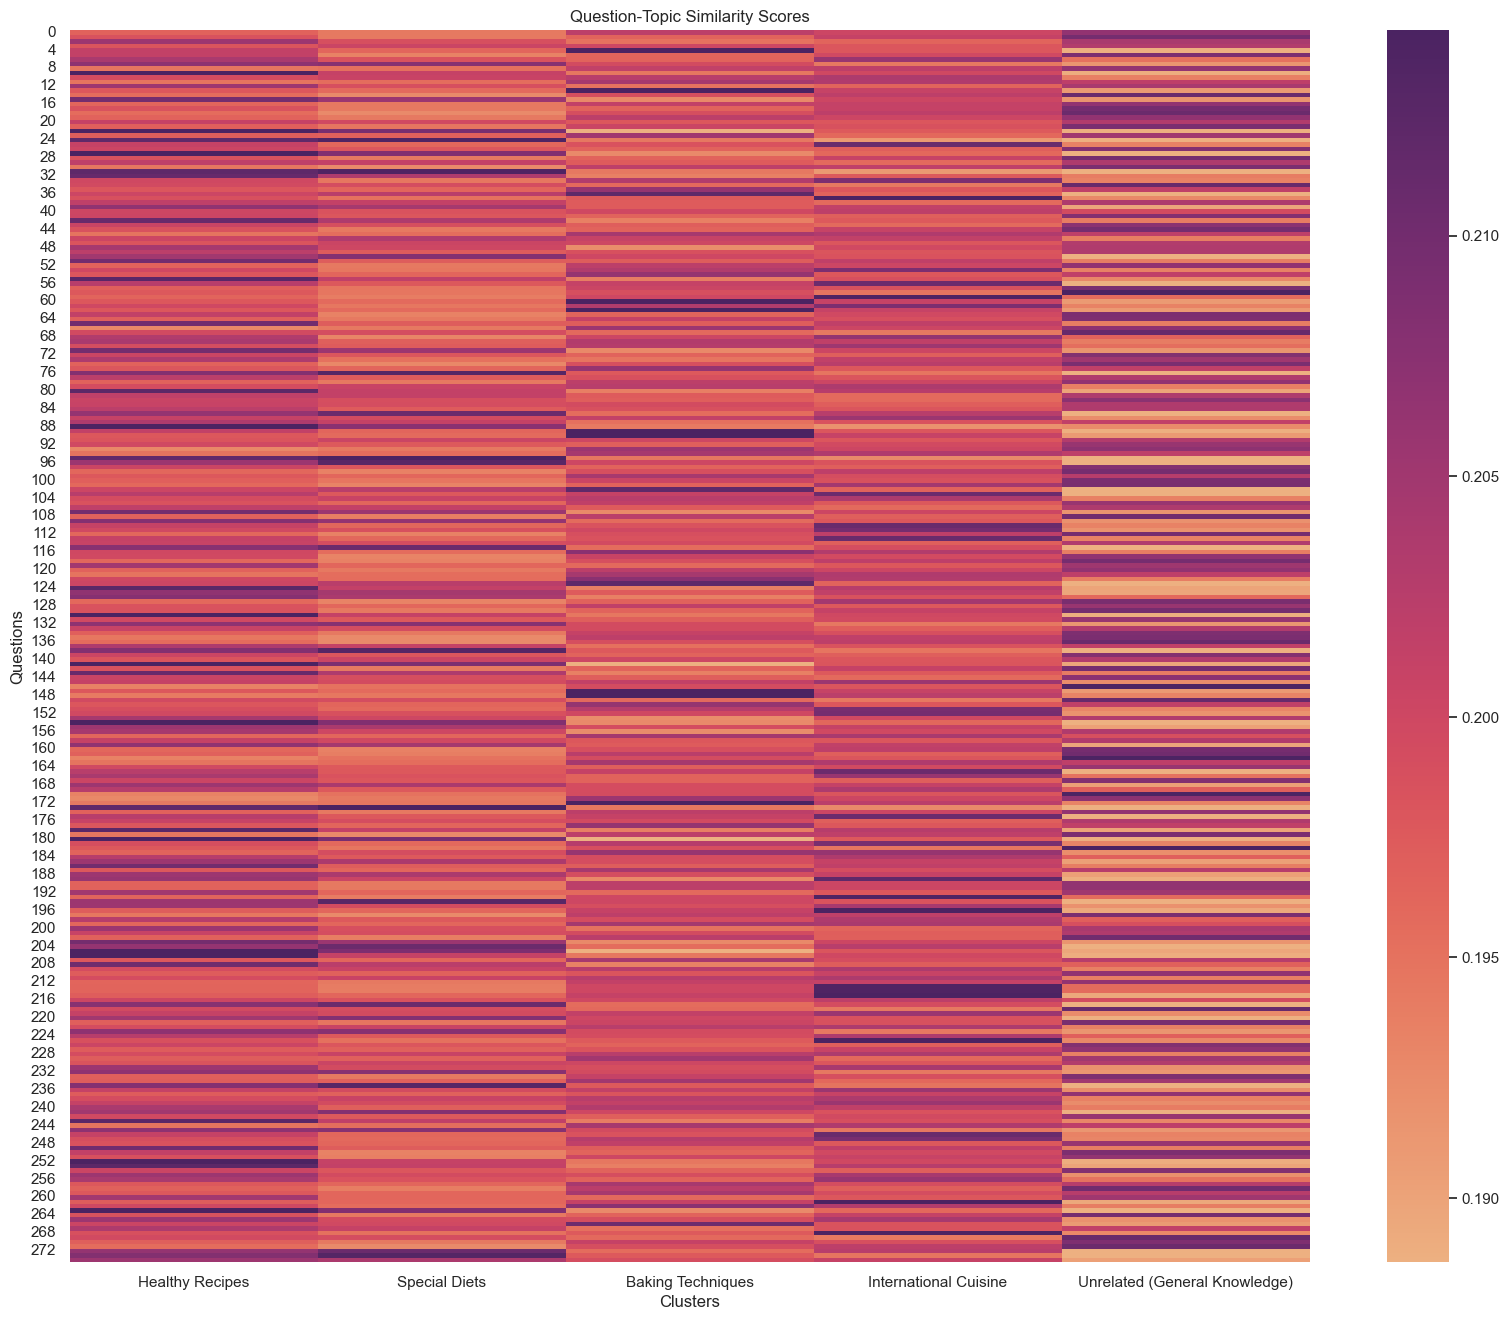

In [7]:
# Rows represent questions, and columns represent clusters
num_questions = len(questions)
num_clusters = len(cluster_embeddings)

similarity_matrix = np.zeros((num_questions, num_clusters))
for i, query_embedding in enumerate(question_embeddings):
    for j, (cluster, cluster_embedding) in enumerate(cluster_embeddings.items()):
        similarity_matrix[i, j] = vector_similarity(query_embedding, cluster_embedding)

# Create the heatmap from row-normalised values
plt.figure(figsize=(20, 16))
normalized_matrix_row = similarity_matrix / similarity_matrix.sum(axis=1, keepdims=True)
normalized_matrix_row
sns.heatmap(normalized_matrix_row, xticklabels=clusters.keys(), cmap="flare", robust=True)

plt.xlabel("Clusters")
plt.ylabel("Questions")
plt.title("Question-Topic Similarity Scores")

We see that even though a lot of the questions are similar to unrelated clusters, there is still a very strong correlation of some questions with our target topics as indicated by the very dark spots.

Let's see how these questions relate to the clusters in the embedding space. We use the [t-SNE method](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to collapse the embedding vectors to 2 dimensions so we can plot them on a scatter graph.

In [8]:
# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(np.array(question_embeddings))
vis_dims.shape

(275, 2)

In [9]:
category_indices = np.argmax(similarity_matrix, axis=1) # Used for the colour map

Text(0.5, 1.0, 'Questions visualised in the 2d vector embedding space using t-SNE with manually defined clusters')

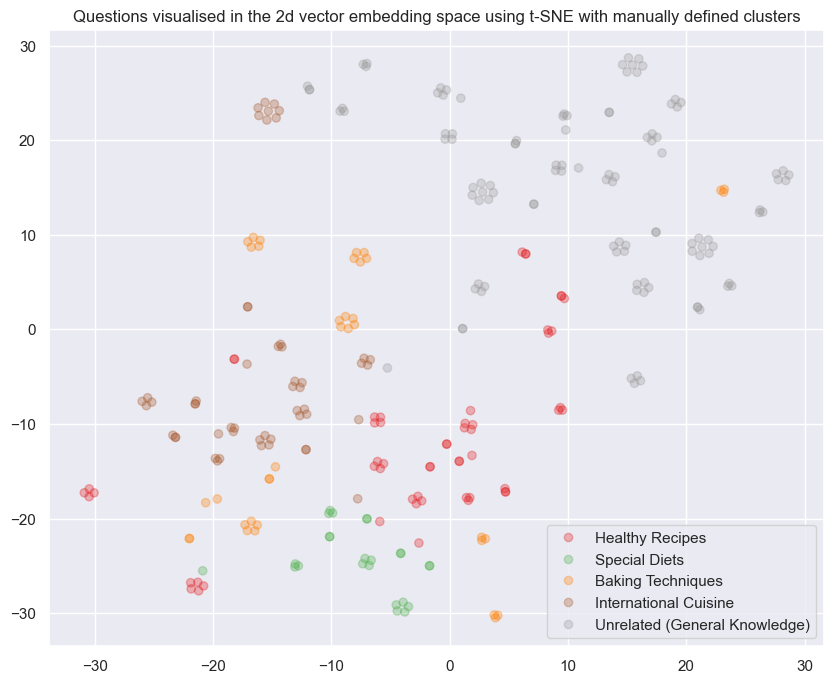

In [10]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(vis_dims[:, 0], vis_dims[:, 1], alpha=0.3, c=category_indices, cmap="Set1")
plt.legend(handles=scatter.legend_elements()[0], labels=clusters.keys())
plt.title("Questions visualised in the 2d vector embedding space using t-SNE with manually defined clusters")

From this scatter plot, we can cleary see that not only have we grossly misunderstood the relative similarity of the questions asked in our dataset but also the amount of clusters we need to understand them. In 2-dimensions, there isn't a clear separation of the manually defined clusters. The clearly visible tight-knit bubbles we see are indicative of cluster groups that we have missed. It seems only our "Special Diets" category is nicely grouped in space, the others appear more scattered. The "International Cuisine" group also appears roughly spatially similar apart from a halo group - this may be indicative of the fact that cusines often overlap with culture and language and this is showing up here. We may need to look in higher dimensions to see that separation. Let's try some automatic detection.

## Automatic Cluster Detection

Manually choosing our clusters is a bit fraught with bias. It is better if we can automatically detect clusters. We saw from our previous attempt that 5 clusters seemed a bit too small for our dataset. Let's try to automatically detect 5 as before and hopefully we we find a better distribution of clusters. To "detect", we will use a well trodden [k-means](https://en.wikipedia.org/wiki/K-means_clustering) clustering approach.

In [11]:
df = pd.DataFrame()
df['question'] = questions
df['embedding'] = question_embeddings
matrix = np.vstack(df.embedding.values)
matrix.shape

(275, 1536)

In [12]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, random_state=42)
kmeans.fit(matrix)
df["Cluster"] = kmeans.labels_

### Auto-naming the clusters using a GPT using samples of each cluster

In [13]:
sample_per_cluster = 8
cluster_names = [None] * n_clusters
for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    questions = "\n".join(
        df[df.Cluster == i]
        .question
        .sample(sample_per_cluster, random_state=42)
        .values
    )
    response = client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=f'What short category/label best fits this list of questions?\n\Questions:\n"""\n{questions}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=10,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    cluster_name = response.choices[0].text.replace("\n", "")
    cluster_names[i] = cluster_name
    print(cluster_name)

    sample_cluster_rows = df[df.Cluster == i].sample(sample_per_cluster, random_state=42)
    for j in range(sample_per_cluster):
        print(sample_cluster_rows.question.str[:70].values[j])

    print("-" * 100)

Cluster 0 Theme:  Cooking and Nutrition
What are some tips for baking with whole wheat flour?
Can you recommend a good recipe for a keto diet?
How to create a balanced vegetarian meal plan?
How to create a balanced vegetarian meal plan?
What are some natural ways to sweeten food without sugar?
What are some creative ways to cook with quinoa?
Can you suggest some low-fat dessert options?
What are some creative ways to cook with quinoa?
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  Personal Finance and Sustainability
How do I create a personal budget?
What are some strategies for saving money?
What are some strategies for saving money?
What are some tips for sustainable gardening?
What are some tips for sustainable gardening?
How to optimize a website for search engines?
How can I reduce my carbon footprint?
How to optimize a website for search engines?
---------------------------------------------------------------

Text(0.5, 1.0, 'Auto Clusters identified visualised in the 2d vector embedding space using t-SNE')

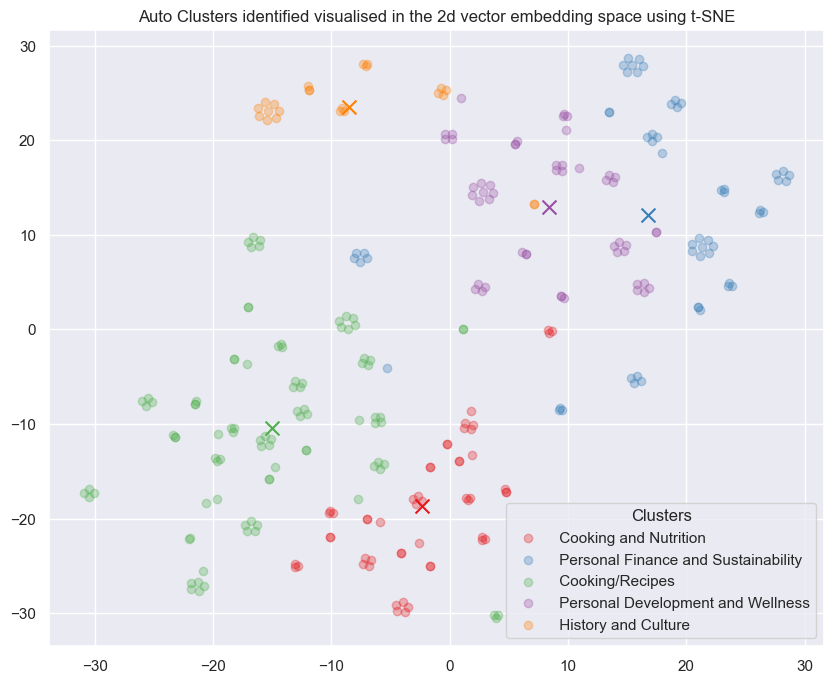

In [14]:
vis_dims2 = tsne.fit_transform(matrix)
x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

colors = sns.color_palette("Set1", n_colors=n_clusters)
handles = []

plt.figure(figsize=(10,8))
for cluster, (name, color) in enumerate(zip(cluster_names, colors)):
    xs = np.array(x)[df.Cluster == cluster]
    ys = np.array(y)[df.Cluster == cluster]
    handle = plt.scatter(xs, ys, color=color, alpha=0.3, label=name)
    handles.append(handle)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)

plt.legend(handles=handles, title="Clusters")
plt.title("Auto Clusters identified visualised in the 2d vector embedding space using t-SNE")

We can see a much more decent data separation than before and the GPT has nicely named these clusters for us. We can see that people are asking a wide range of questions from personal finance to history and cluture. We need to think about how to encourage users to use our chatbot for what it is made for and make sure we put some controls in place for these specific off-categories to ensure our chatbot is not answering what it shouldn't be. Alternatively, we could consider a pivot as a company to cater to these types of quesions.
